In [1]:
%%capture
!pip install fastparquet
!pip install pandarallel
!pip install pystan==2.19.1.1

In [3]:
import pystan
import numpy as np
import pandas as pd
import pickle
from src.utils import create_output_directories
import seaborn as sns
#Set up parallel processing
from pandarallel import pandarallel
from tqdm.notebook import trange, tqdm
from src.tables import get_table
import os
import pickle
os.environ["TMPDIR"] = "/home/joebak/tmp"

pandarallel.initialize(nb_workers=8,verbose=True,progress_bar=True)
tqdm.pandas()

#Make sure things reload
%load_ext autoreload
%autoreload 2

root = '.'
pal = sns.color_palette("Set2",n_colors=8)

create_output_directories()

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<h1>Overview</h1>

Below is the code necessary to recreate the analysis from "Combining interventions to reduce the spread of viral misinformation." This notebook assumes that there is a folder located in "root" (default '.') called "data" containing:
<ol>
<li>Directory: Timeseries with subdirectories:</li>
    <ul>
    <li>aggressive</li>
    <li>modest</li>
    <li>currently</li>
    <li>Verified</li>
    <li>500k, 100k, 50k, 10k</li>
    <li>aggregated</li>
    <li>raw</li>
     </ul>
<li>ban_df_counts.parquet</li>
<li>events.parquet</li>
<li>incidents.parquet</li>
</ol>

Each of the subdirectories should contain aggregated time-series data, downloaded from LINK for each of the unfiltered events. This data were generated from our raw data which is not shared for privacy concerns. However, we include the code used to generate the aggregated time-series for application to novel datasets.


<h1>Segmentation and model fit</h1>

<h2>Segmentation</h2>

We begin by segmenting the time series of incidents into distinct events. Here, we define events as periods of heightened activity. Boundaries between events occur when the volume of tweets follows below 5% of the maximum 5-minute post volume for that event  (paramters before_min, after_min in srcseg.get_peaks). Events within an incident are included if their peak height is at least 30% of the maximum peak height across the entire incident (parameter pmin for srseg.get_peaks). 

In [3]:
incidents = pd.read_csv('./data/incidents.csv')

In [4]:
import src.segmentation as srcseg

def event_df(row):
    peaks = srcseg.get_peaks(row,root='.',start=0, freq=5,pmin=.3,
                      after_min=.05, before_min=.05)
    event_dictionaries = []
    for idx, peak in enumerate(peaks):
        one_event = {'incident_name':row['incident_name'],
                     'start':peak[0],
                     'end':peak[1],
                     'event_name':row['incident_name']+'_event_'+str(idx)}
        event_dictionaries.append(one_event)
    return pd.DataFrame(event_dictionaries)


events = pd.concat([pd.DataFrame(item) for item in incidents.T.parallel_apply(event_df,
                                                                     result_type='reduce')])
events = pd.merge(events, incidents, left_on='incident_name', right_on='incident_name')
events = events[(events['end'] - events['start']) >=12]
events.to_csv(root + '/data/events.csv',compression=None)
print('Found %s events' % str(events.shape[0]))
_ = events.T.parallel_apply(srcseg.plot_event)

Found 544 events


<h2> Fit model to all events </h2>

With events segmented, we turn to evaluating our model fit with regards to each event. Our model, in its simplest form  can be described as: 

\begin{equation}
\label{eq1}
\begin{aligned}
    y_{t} &=  \exp(\alpha + \beta v_{t-1})\\
    v_{t} &= v_{t-1} \delta e^{-\lambda t} + x[t] \\
    x_{t} &= \log(\sum_{j=1}^{y_t} F_{j})
\end{aligned}
\end{equation}

Where $y_t$ are the tweets at time $t$, $\alpha$ is the baseline rate of discussion, and $\beta$ is the effect of virality, $v$. Virality decays exponentially as a function of $\delta$ and $\lambda$. Here, $\delta$ captures the baseline rate of decay per time step, and $\lambda$ controls the way in which that decay changes over the lifetime of an event. This could either be due to algorithmic processes favoring new content or, for very large events, user saturation. Every time step, for each of $y_t$ accounts, the log sum ($x_t$) of their followers, $F_j$ is added to virality for the subsequent time step. We translate this into a bayesian statistical model such that: 

\begin{align*}
y_{t} &\sim \text{NegativeBinomial2}(\mu_{t}, \phi) \text{ for }t=2...T \\ 
\mu_{i} &= \exp(\alpha + \beta v_{t-1})\text{ for  }t=2...T \\ 
v_{t} &= v_{t-1}\delta e^{-\lambda t} + x_{t} \\
\alpha &\sim \text{Normal}(-3,3) \\
\beta &\sim \text{Normal}(0,3) \\
\delta &\sim \text{Beta}(2,2) \\
\lambda &\sim \text{HalfExponential}(1) \\
\phi &\sim \text{HalfExponential}(1) \\ 
v_{1} &= x_{1}\\
x_{t} &= \log(\sum_{j=1}^{y_t} F_{j}+1)
\end{align*}

This model can be found in /src/timeseries.stan. Because our model makes assumptions about how misinformation cascades spread, it is unlikely to fit everything that is considered an event. Ways in which we can identify a failed fit include parameters not converging, divergent transitions, or the posterior predictive distribution of cascade sizes not containing observed value. Here, we load the model and apply it to each segmented event. We then evaluate inclusion criteria and plot all successfully fitted events for visual inspection. Note that Stan will (and should) yell at us when events fail to fit. This is expected at this stage. 


In [6]:
events = pd.read_csv(root + '/data/events.csv')

In [7]:
#Compile model, we only need to do this once. 
model = pystan.StanModel(root + '/src/timeseries.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e9b01ffa7f928081550461f3ea02ee79 NOW.
In file included from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/pystan_mnp_y8kz/stanfit4anon_model_e9b01ffa7f928081550461f3ea02ee79_8972530506379957197.cpp:777:
/opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

KeyboardInterrupt



In [7]:
pickle.dump(model, open(root + '/output/posteriors/model.p','wb'))

In [8]:
model = pickle.load(open(root + '/output/posteriors/model.p','rb'))

In [9]:
events['duration'] = events['end'] - events['start']
events.sort_values('duration',inplace=True)

In [10]:
#Fit model to all events, save them. 
#This will take a while
#We will get some divergent transitions,warnings
#But we're not expecting our model to fit every time series
import src.model_fit as srcmf
diagnostics = []
for idx in tqdm(range(events.shape[0])):
    diagnostics.append(srcmf.fit_model(events.iloc[idx],model,keep=True))

  0%|          | 0/544 [00:00<?, ?it/s]

In [11]:
import src.model_fit as srcmf

In [12]:
row = events.iloc[3]
out= events.T.progress_apply(srcmf.check_fit)
events = pd.DataFrame.from_records(out)

  0%|          | 0/544 [00:00<?, ?it/s]

--------
riot:_crimethinc_event_3
--------
coup:_Frozen_Election_event_0
--------
Statistics:_2%_Strategy__event_0
--------
lost:_Biden_truck_ballots_event_1
--------
tech:_Russian_Malware_ES&S_Diebold_event_2
--------
intimidation:_threat_letter_event_1
--------
USPS:_28_million_missing_ballots_event_4
--------
USPS:_28_million_missing_ballots_event_5
--------
voting_info:_NY_voting_process_event_0
--------
poll_watchers:_Infographic_Picture_event_0
--------
In_Person_Fraud:_OHare_Airport_event_3
--------
USPS:_PA_Long_Wait_event_1
--------
False_Victory:_Eric_Trump_Calls_PA_event_0


--------
Prominent_Person:_Marjorie_Green_STS_event_1
--------
Digital_dumps:_AARP_Aggregate_event_0
--------
voting_info:_12th_Amendment_event_0
--------
voting_info:_12th_Amendment_event_1
--------
voting_info:_12th_Amendment_event_2


--------
voting_info:_ads_say_vote_not_counted_event_0
--------
Prominent_Person:_Cuddy_Camaro_event_0
--------
riot:_democrat-led_election_violence_event_0
--------
lost:_desert_ballots_event_1
--------
Physical_Mail_Mistakes:_Misprints_GA_event_0


--------
Physical_Mail_Fraud:_CCP_Fake_Ballots_event_0
--------
Voting_Twice:_Melania_Votes_event_1
--------
Other:_WA_Miscellaneous_Fraud_event_0
--------
riot:_democrat-led_election_violence_event_8
--------
riot:_democrat-led_election_violence_event_7


--------
riot:_democrat-led_election_violence_event_2
--------
tech:_FL_voter_info_leaked_event_0
--------
riot:_democrat-led_election_violence_event_3
--------
riot:_democrat-led_election_violence_event_1
--------
voting_info:_abuse_and_public_records_event_4
--------
riot:_mis-framed_trump_email_event_1
--------
partisan_vcr:__AZ_hand_recount_required_event_1
--------
Other:_WA_Miscellaneous_Fraud_event_5
--------
Other:_WA_Miscellaneous_Fraud_event_3


--------
lost:_PA,GA_dumpster_ballots_event_1
--------
Other:_Voter_Fraud_Cases_event_1
--------
lost:_NJ_dumpster_event_1
--------
Other:_QAnon_Claims_event_0
--------
Other:_provisional_ballots_event_0
--------
lost:_VA_60k_undelivered_ballots_event_1
--------
USPS:_28_million_missing_ballots_event_3
--------
USPS:_28_million_missing_ballots_event_1


--------
riot:_crimethinc_event_9
--------
Prominent_Person:_Tom_Fitton_Livestream_VBM_event_0
--------
riot:_riot_and_looting_around_elections_event_0
--------
voting_info:_NC_wrong_ballot_event_1
--------
Statistics:_Wisconsin_Votes_>_Registered_event_0
--------
riot:_crimethinc_event_0
--------
Ineligible_Voters:_TX_Illegal_Voters_event_6
--------
lost:_VA_60k_undelivered_ballots_event_3
--------
supression:_riggedthefilm_event_0
--------
Prominent_Person:_Clay_Higgins_event_0
--------
Physical_Mail_Fraud:_GA_Democrats_Fixing_Ballots_event_0
--------
Other:_QAnon_Claims_event_2


--------
riot:_crimethinc_event_1
--------
voting_info:_MS_return_absentee_ballots_in_person_event_1
--------
partisan_vcr:__Michigan_Republican_applications_event_1
--------
lost:_VA_60k_undelivered_ballots_event_2


--------
Statistics:_JW_Counties_Over_100%_event_8
--------
lost:_PA_shredded_ballot_applications_event_3
--------
partisan_vcr:__Pennsylvania_inner_envelopes_event_1
--------
False_Victory:_PA_early_calls_event_1
--------
Prominent_Person:_Cuddy_Camaro_event_2


--------
lost:_VA_60k_undelivered_ballots_event_0
--------
Other:_PragerU_Video_event_0
--------
Physical_Mail_Mistakes:_Knox_County_event_0
--------
Physical_Mail_Mistakes:_Misprints_GA_event_1
--------
poll_watchers:_Trump_suit_event_0


--------
intimidation:_BLM_Antifa_Intimidation_Plans_event_3
--------
partisan_vcr:__Michigan_delays_event_1
--------
USPS:_28_million_missing_ballots_event_2
--------
Late:_OK_Ballots_Found_event_0
--------
lost:_Biden_truck_ballots_event_0
--------
Ineligible_Voters:_Undocumented_WA_event_0
--------
Other:_WA_Rejected_Ballots_event_0
--------
voting_info:_anyone_can_votes_as_often_as_you_wish_event_0
--------
Statistics:_African-American_Ballot_Rejections_event_2
--------
supression:_GA_national_guard_event_0
--------
voting_info:_abuse_and_public_records_event_3
--------
voting_info:_MS_return_absentee_ballots_in_person_event_0
--------
Physical_Mail_Fraud:_Newsom_VBM_event_0
--------
Physical_Mail_Fraud:_WA_fraud_claims_event_0
--------
Other:_WA_Miscellaneous_Fraud_event_1
--------
Prominent_Person:_Tom_Fitton_Livestream_VBM_event_2
--------
voting_info:_US_constitution_amendment_event_1


--------
Physical_Mail_Fraud:_CCP_Fake_Ballots_event_2
--------
Physical_Mail_Fraud:_PA_Court_Time_Ruling_event_1
--------
Prominent_Person:_Jody_Hice_event_0
--------
partisan_vcr:__Erie_ballots_thrown_away_event_0
--------
intimidation:_BLM_Antifa_Intimidation_Plans_event_1


--------
riot:_crimethinc_event_7
--------
Other:_Fulton_County_Water_Pipe_event_1
--------
lost:_LA,TX_dumpster_ballots_event_0
--------
Statistics:_JW_Counties_Over_100%_event_10
--------
coup:_sunrise_movement_event_0


--------
Physical_Mail_Mistakes:_NJ_Ballot_to_AL_event_0
--------
protest:_Black_Lives_Matter_plaza_unrest_event_0
--------
Late:_PA_Late_Ballots_event_0
--------
Prominent_Person:_Tom_Fitton_Livestream_VBM_event_1


--------
riot:_crimethinc_event_6
--------
partisan_vcr:__Kristie_Alley_Facebook_Retweet_event_0
--------
Other:_WA_Miscellaneous_Fraud_event_4
--------
Other:_Allegheny_County_Family_Votes_for_each_other_event_0
--------
lost:_multistate_thrown_ballots_event_0
--------
Statistics:_Kentucky_Fraud_event_1
--------
protest:_Black_Lives_Matter_plaza_unrest_event_1
--------
protests:_portland_unrest_event_1
--------
voting_info:_poll_worker_ballot_marks_event_3
--------
riot:_crimethinc_event_10
--------
voting_info:_US_constitution_amendment_event_0
--------
intimidation:_FL_Antifa_and_Loomer_event_0
--------
Other:_Manufactured_Stolen_Early_Votes_event_3
--------
ballot_stuffing:_NJ_poll_watcher_event_1


--------
Prominent_Person:_Marjorie_Green_STS_event_0
--------
Physical_Mail_Fraud:_CCP_Fake_Ballots_event_1
--------
riot:_democrat-led_election_violence_event_9
--------
Statistics:_Chinese_Language_Election_Storm_event_0
--------
In_Person_Fraud:_Blind_Relatives_event_0
--------
tech:_ElectionGuard_event_0


--------
ballot_stuffing:_No_down_ticket_event_1
--------
riot:_democrat-led_election_violence_event_4
--------
False_Victory:_GA_called_for_Trump_event_2
--------
Statistics:_JW_Counties_Over_100%_event_7
--------
Other:_QAnon_Coup_D'Etat_event_2
--------
supression:_Spanish_Language_Supression_at_Polls_event_0
--------
Other:_Manufactured_Stolen_Early_Votes_event_5
--------
Other:_trump_tweet_censored_event_0
--------
Statistics:_JW_Counties_Over_100%_event_5
--------
USPS:_28_million_missing_ballots_event_0
--------
partisan_vcr:__live_tv_fraud_event_2
--------
ballot_stuffing:_NJ_poll_watcher_event_0
--------
tech:_FL_voter_info_leaked_event_2
--------
suppression:_robocall_stay_safe_event_2
--------
lost:_multistate_dumped_ballots_event_0
--------
Voting_Twice:_NH_2016_Double_Vote_event_0
--------
Physical_Mail_Fraud:_PA_Printed_Ballots_event_0
--------
riot:_crimethinc_event_5


--------
ballot_box:_Franklin_County_Police_event_0
--------
Other:_QAnon_Claims_event_5
--------
Statistics:_Kentucky_Fraud_event_0
--------
tech:_Russia_2016_Hacking_event_3
--------
Digital_dumps:_Jo_Jorgensen_PA_event_0
--------
Late:_OK_Ballots_Found_event_2
--------
riot:_antifa_burning_things_down_event_1
--------
Physical_Mail_Fraud:_GA_Democrats_Fixing_Ballots_event_2


--------
Georgia_scam_event_0
--------
USPS:_Fake_Votes_event_0
--------
Other:_TX_Disabled_Residents_event_1
--------
supression:_NJ_not_allowed_to_vote_event_0
--------
riot:_crimethinc_event_8
--------
partisan_vcr:__Michigan_Republican_applications_event_2
--------
Physical_Mail_Fraud:_Postal_Worker_Affiliation_event_1
--------
partisan_vcr:__live_tv_fraud_event_1
--------
coup:_color_revolution_event_5
--------
protests:_portland_unrest_event_0
--------
suppression:_robocall_stay_safe_event_1


--------
tech:_Russia_2016_Hacking_event_4
--------
Other:_QAnon_Claims_event_4
--------
USPS:_NJ_worker_dumps_mail_event_0
--------
supression:_NJ_disabled_only_event_1
--------
Statistics:_JW_Counties_Over_100%_event_6
--------
Other:_QAnon_Claims_event_1
--------
Voting_Twice:_CA_Video_event_0


--------
Prominent_Person:_O'Keefe_NYC_Fraud_event_0
--------
Physical_Mail_Fraud:_Postal_Worker_Affiliation_event_0
--------
Ineligible_Voters:_TX_Illegal_Voters_event_5
--------
voting_info:_abuse_and_public_records_event_2
--------
Other:_Manufactured_Stolen_Early_Votes_event_4
--------
Ineligible_Voters:_TX_Illegal_Voters_event_4


--------
lost:_VA_60k_undelivered_ballots_event_4
--------
Physical_Mail_Fraud:_MI_Drops_Fake_Ballots_event_0
--------
voting_info:_poll_worker_ballot_marks_event_0
--------
False_Victory:_GA_called_for_Trump_event_1
--------
riot:_mis-framed_trump_email_event_2
--------
In_Person_Fraud:_OHare_Airport_event_0
--------
Ineligible_Voters:_WA_Ineligible_Sister_event_0
--------
riot:_democrat-led_election_violence_event_5
--------
Machines:_No_Ink_Green_Bay_event_0
--------
riot:_antifa_burning_things_down_event_8


--------
riot:_crimethinc_event_4
--------
riot:_crimethinc_event_2
--------
Machines:_Westmoreland_machines_down_event_0
--------
partisan_vcr:__Michigan_delays_event_0


--------
tech:_FL_voter_info_leaked_event_1
--------
lost:_KY_dumped_ballots_event_0
--------
Statistics:_JW_Counties_Over_100%_event_4
--------
intimidation:_PA_State_Constable_event_0
--------
Digital_dumps:_Germany_Ambassador_event_1
--------
Statistics:_Benford's_Law_event_0
--------
lost:_CA_dumpster_event_1


--------
Other:_Ballot_Fraud_Poll_Watcher_Votes_event_0
--------
Other:_DeKalb_Rejected_Ballots_event_0
--------
Physical_Mail_Fraud:_ACLU_Signatures_event_1
--------
ballot_stuffing:_MI_Van_Votes_event_1
--------
Voting_Twice:_Hannity_Virginia_Voters_event_5
--------
Voting_Twice:_NH_2016_Double_Vote_event_1


--------
partisan_vcr:__Michigan_Republican_applications_event_6
--------
intimidation:_PA_State_Constable_event_1
--------
lost:_NV_trash_ballots_event_1
--------
partisan_vcr:__Michigan_Republican_applications_event_0
--------
False_Victory:_NC_Early_Call_event_0
--------
ballot_harvesting:_Granny_farming__event_2


--------
Voting_Twice:_Hannity_Virginia_Voters_event_3
--------
Physical_Mail_Fraud:_ACLU_Signatures_event_2
--------
Other:_QAnon_Claims_event_3
--------
dead_voters:_list_of_100+_event_0
--------
Voting_Twice:_5_Ballots_event_0
--------
riot:_antifa_burning_things_down_event_4


--------
Statistics:_Benford's_Law_event_1
--------
Ineligible_Voters:_TX_Illegal_Voters_event_1
--------
dead_voters:_FL_dead_wife_event_0
--------
False_Victory:_WI_SOS_Website_Results_event_0
--------
coup:_color_revolution_event_7


--------
riot:_antifa_burning_things_down_event_5
--------
Physical_Mail_Mistakes:_NJ_Undeliverable_Ballots_event_0
--------
tech:_Russia_2016_Hacking_event_0
--------
coup:_NV_Early_Call_Coup_event_0
--------
lost:_PA_shredded_ballot_applications_event_4
--------
coup:_color_revolution_event_2


--------
Physical_Mail_Fraud:_Obama_Printers_event_1
--------
coup:_color_revolution_event_3
--------
Statistics:_JW_Counties_Over_100%_event_9
--------
lost:_AZ_rock_ballots_event_0
--------
Late:_NC_Stolen_event_0
--------
dead_voters:_NY_post_ballots_event_0


--------
lost:_LA,TX_dumpster_ballots_event_1
--------
Prominent_Person:_Ghost_Ballots_event_0
--------
False_Victory:_GA_called_for_Trump_event_0
--------
Physical_Mail_Fraud:_GA_Democrats_Fixing_Ballots_event_1
--------
Late:_OK_Ballots_Found_event_5
--------
voting_info:_abuse_and_public_records_event_0


--------
lost:_AZ_rock_ballots_event_1
--------
intimidation:_Proud_Boys_Email_event_0
--------
Physical_Mail_Fraud:_WA_Stolen_Ballot_Bag_event_1
--------
Physical_Mail_Fraud:_USPS_PA_Whistleblower_event_0
--------
Physical_Mail_Fraud:_NY_Post_Confession_event_2


--------
Ineligible_Voters:_TX_Illegal_Voters_event_3
--------
Other:_QAnon_Coup_D'Etat_event_1
--------
Other:_Manufactured_Stolen_Early_Votes_event_2
--------
ballot_harvesting:_Granny_farming__event_1
--------
lost:_VA_burned_ballots_event_0


--------
False_Victory:_WI_SOS_Website_Results_event_1
--------
Voting_Twice:_Melania_Votes_event_0
--------
Voting_Twice:_Hannity_Virginia_Voters_event_6
--------
civil_war:_general_ticket_event_4


--------
Late:_Extended_Ballots_event_0
--------
Other:_Manufactured_Stolen_Early_Votes_event_0
--------
voting_info:_ballot_surredering_event_1
--------
Other:_QAnon_Coup_D'Etat_event_0
--------
coup:_color_revolution_event_6


--------
Prominent_Person:_Crowder_MI_Claims_event_0
--------
Statistics:_Math_Video_event_1
--------
intimidation:_CA_BLM_protest_event_0
--------
lost:_OH_2014_event_1
--------
Physical_Mail_Fraud:_PA_Misprinted_Corrections_event_1
--------
partisan_vcr:__AZ_hand_recount_required_event_0


--------
USPS:_Postal_Workers_Partisan_event_0
--------
riot:_democrat-led_election_violence_event_6
--------
Prominent_Person:_Press_Secretary_Fraud_event_0
--------
Ineligible_Voters:_Illegal_Immigrant_Registrations_event_0
--------
Physical_Mail_Fraud:_Press_Secretary_event_0


--------
dead_voters:_general_ticket_event_4
--------
Statistics:_JW_Counties_Over_100%_event_1
--------
partisan_vcr:__Pennsylvania_inner_envelopes_event_0
--------
Voting_Twice:_Hannity_Virginia_Voters_event_4
--------
tech:_Russia_2016_Hacking_event_5


--------
poll_watchers:_Philly_denied_entry_2_event_1
--------
intimidation:_BLM_Antifa_Intimidation_Plans_event_2
--------
intimidation:_PA_armed_men_confront_vote_counter_event_0
--------
tech:_Russia_2016_Hacking_event_6
--------
Other:_Fulton_County_Water_Pipe_event_0
--------
Machines:_MI_Power_Outages_event_0


--------
lost:_PA_shredded_ballot_applications_event_5
--------
Other:_WA_Miscellaneous_Fraud_event_2
--------
partisan_vcr:__Philadelphia_separate_lines_event_0
--------
lost:_desert_ballots_event_0
--------
intimidation:_NY_long_island_event_0
--------
USPS:_PA_Mail_Carrier_Trash_Ballot_event_0


--------
ballot_stuffing:_No_down_ticket_event_0
--------
Prominent_Person:_Cuddy_Camaro_event_1
--------
Physical_Mail_Fraud:_NY_Post_Confession_event_1
--------
supression:_TX_immigrant_mistreatment_event_2
--------
supression:_NJ_disabled_only_event_0


--------
ballot_harvesting:_Granny_farming__event_0
--------
lost:_KY_dumped_ballots_event_1
--------
riot:_antifa_burning_things_down_event_3
--------
Statistics:_Wisconsin_Votes_>_Registered_event_1
--------
Ineligible_Voters:_TX_Illegal_Voters_event_0
--------
Machines:_Ivanka_patent_event_0
--------
civil_war:_general_ticket_event_2
--------
Other:_TX_Disabled_Residents_event_2


--------
Statistics:_Cities_That_Matter_event_0
--------
ballot_box:_Collecting_After_Election_event_5
--------
partisan_vcr:__Michigan_Republican_applications_event_3
--------
lost:_MA_primary_ballots_event_0
--------
USPS:_FL_Mail_Room_event_1
--------
Digital_dumps:_Germany_Ambassador_event_0
--------
False_Victory:_PA_early_calls_event_0
--------
Physical_Mail_Fraud:_PA_Misprinted_Corrections_event_0


--------
MI_and_PA_dead_voting_list_event_2
--------
lost:_NV_trash_ballots_event_0
--------
Voting_Twice:_Hannity_Virginia_Voters_event_1


--------
coup:_color_revolution_event_10
--------
Physical_Mail_Fraud:_PA_Court_Time_Ruling_event_0
--------
Statistics:_JW_Counties_Over_100%_event_0
--------
Statistics:_Wisconsin_Votes_>_Registered_event_4
--------
Physical_Mail_Fraud:_FEC_Chair_event_0
--------
lost:_PA_shredded_ballot_applications_event_1
--------
supression:_TX_immigrant_mistreatment_event_3
--------
ballot_stuffing:_MI_wagons_suitcases_and_coolers_event_1
--------
ballot_stuffing:_MI_Van_Votes_event_0
--------
Digital_dumps:_Michigan_128,000_votes_event_0
--------
suppression:_robocall_stay_safe_event_0
--------
ballot_box:_Collecting_After_Election_event_1
--------
Other:_Manufactured_Stolen_Early_Votes_event_1
--------
Other:_Voter_Fraud_Cases_event_0
--------
Georgia_scam_event_1
--------
Other:_Stop_The_Steal_Pushed_event_4
--------
False_Victory:_PA_Attorney_General_Calls_Election_event_1
--------
riot:_antifa_burning_things_down_event_6


--------
tech:_Hammer_and_Scorecard_event_1
--------
USPS:_FL_23%_rejected_mail-in_event_2
--------
lost:_PA_shredded_ballot_applications_event_2


--------
coup:_color_revolution_event_0
--------
partisan_vcr:__Joke_ballot_ripping_event_0
--------
supression:_TX_immigrant_mistreatment_event_5
--------
partisan_vcr:__Michigan_Republican_applications_event_5


--------
ballot_harvesting:_Michigan_Union_event_0
--------
Other:_Ballot_Fraud_Poll_Watcher_Votes_event_1
--------
lost:_PA_300-500k_event_0
--------
Voting_Twice:_Hannity_Virginia_Voters_event_2


--------
lost:_NJ_Mail_Photo_event_1
--------
protests:_stop_the_steal_rallies_event_0
--------
voting_info:_12th_Amendment_event_3
--------
dead_voters:_voters_in_their_170s_event_0
--------
Statistics:_Math_Video_event_0
--------
voting_info:_CO_postcards_event_0
--------
ballot_box:_Collecting_After_Election_event_2
--------
partisan_vcr:__Michigan_Republican_applications_event_4
--------
USPS:_PA_stop_delivery_whistleblower_event_0
--------
tech:_Russia_2016_Hacking_event_1
--------
tech:_Dr._Shiva_MI_Glitch_event_0
--------
poll_watchers:_Philly_no_entry_list_event_1
--------
tech:_Russian_Malware_ES&S_Diebold_event_0
--------
supression:_TX_immigrant_mistreatment_event_4
--------
voting_info:_CO_postcards_event_1
--------
Voting_Twice:_PA_Duplicates_event_1


--------
partisan_vcr:__Pennsylvania_poll_worker_empty_ballots_event_1
--------
lost:_NJ_dumpster_event_2
--------
riot:_antifa_burning_things_down_event_0
--------
Ballot_harvesting:_Minnesota_Somali_voters_event_0
--------
In_Person_Fraud:_Blind_Relatives_event_1
--------
voting_info:_NC_wrong_ballot_event_0
--------
coup:_color_revolution_event_4
--------
USPS:_NV_Veritas_event_0
--------
riot:_mis-framed_trump_email_event_0


--------
USPS:_300,000_Undelivered_Ballots_event_0
--------
Physical_Mail_Fraud:_FEC_Chair_event_1
--------
poll_watchers:_Philly_no_entry_list_event_2
--------
Statistics:_Benford's_Law_event_2
--------
Statistics:_Kentucky_Fraud_event_2


--------
intimidation:_trump_calls_for_monitors_event_0
--------
tech:_antrim_vote_count_event_0
--------
supression:_TX_immigrant_mistreatment_event_1
--------
lost:_OH_2014_event_0
--------
poll_watchers:_Philly_no_entry_list_event_0


--------
ballot_box:_Collecting_After_Election_event_0
--------
Prominent_Person:_Darin_Southam_event_0
--------
Physical_Mail_Mistakes:_MI_Misprints_for_Troops_event_0
--------
voting_info:_MI_robocalls_event_0
--------
coup:_SECDEF_Threat_event_0
--------
Ineligible_Voters:_TX_Illegal_Voters_event_2
--------
partisan_vcr:__Pennsylvania_delays_event_0
--------
Late:_OK_Ballots_Found_event_3
--------
Statistics:_JW_Counties_Over_100%_event_2
--------
partisan_vcr:__Detroit_provisional_ballots_event_0
--------
Other:_Venezuela_Methods_event_0
--------
Ballot_harvesting:_Baltimore_elderly_votes_event_0
--------
ballot_harvesting:_Baltimore_elderly_votes_event_0
--------
Statistics:_Cities_That_Matter_event_1
--------
intimidation:_NC_BLM_event_0
--------
dead_voters:_general_ticket_event_5
--------
Statistics:_JW_Counties_Over_100%_event_3
--------
voting_info:_poll_worker_ballot_marks_event_2
--------
Physical_Mail_Fraud:_Philly_Destroying_Envelopes_event_0


--------
voting_info:_abuse_and_public_records_event_1
--------
riot:_antifa_burning_things_down_event_7
--------
Statistics:_Wisconsin_Votes_>_Registered_event_3
--------
ballot_stuffing:_MI_wagons_suitcases_and_coolers_event_0


--------
lost:_NJ_Mail_Photo_event_0
--------
ballot_stuffing:_Short_Lines_Fraud_event_0
--------
False_Victory:_RealClearPolitics_Rescinds_Call_of_PA_event_0
--------
civil_war:_general_ticket_event_1
--------
tech:_Zuckerberg_Hacking_WI_event_0
--------
Physical_Mail_Fraud:_ACLU_Signatures_event_0
--------
voting_info:_CA_fake_voting_center_event_0


--------
dead_voters:_general_ticket_event_0
--------
Physical_Mail_Mistakes:_Deceased_and_Inactive_CA_event_0
--------
tech:_Russian_Malware_ES&S_Diebold_event_1
--------
lost:_GA_found_in_dumpster_event_1
--------
Prominent_Person:_Chanel_Rion_Memo_event_0
--------
intimidation:_FL_trump_police_officer_event_0
--------
partisan_vcr:__Pennsylvania_poll_worker_empty_ballots_event_2
--------
voting_info:_ballot_surredering_event_0
--------
ballot_stuffing:_Don_Jr_Trump_Army_event_0
--------
Other:_urban_playbook_event_0
--------
voting_info:_poll_worker_ballot_marks_event_1
--------
Machines:_NYC_Broken_event_0
--------
ineligible_voters:_nv_residency_violations_event_0
--------
Other:_Candidate_Fraud_Hannity_Misquote_event_0
--------
dead_voters:_voters_in_their_170s_event_1
--------
Statistics:_Numerical_Anomalies_event_1


--------
dead_voters:_team_trump_event_0
--------
Statistics:_98K_PA_Voters_event_1
--------
Other:_Trump_Campaign_Quote_event_0
--------
Statistics:_Numerical_Anomalies_event_0


--------
Physical_Mail_Fraud:_WA_Stolen_Ballot_Bag_event_0
--------
poll_watchers:_Philly_denied_entry_2_event_0
--------
coup:_color_revolution_event_1
--------
tech:_Feinstein_Pelosi_Election_Software_event_0
--------
Other:_TX_Disabled_Residents_event_0
--------
Voting_Twice:_Gateway_Pundit_Election_Officials_event_0
--------
Machines:_Franklin_Spalding_County_Hack_event_0
--------
tech:_Zuckerberg_Hacking_WI_event_1
--------
riot:_nigel_farage_prediction_event_0
--------
Physical_Mail_Fraud:_NY_Pre-Filled_Biden_event_0
--------
Voting_Twice:_PA_Duplicates_event_0
--------
Physical_Mail_Fraud:_PA_Court_Signature_Ruling_event_0
--------
ballot_box:_Collecting_After_Election_event_4
--------
ballot_harvesting:_new_Michigan_law_event_0
--------
ballot_harvesting:_Biden_Texas_Director_event_1


--------
partisan_vcr:__Philadelphia_missing_supervisor_event_0
--------
Machines:_Ivanka_patent_event_1
--------
Late:_NC_Stolen_event_1


--------
dead_voters:_general_ticket_event_1
--------
USPS:_FL_23%_rejected_mail-in_event_0


--------
Physical_Mail_Fraud:_NY_Post_Confession_event_0
--------
civil_war:_general_ticket_event_0
--------
Statistics:_98K_PA_Voters_event_0
--------
Other:_drive_through_voting_illegal_driver's_licenses_event_0


--------
supression:_TX_immigrant_mistreatment_event_0
--------
voting_info:_vote_by_mail_for_warrants_robocalls_event_0


--------
Other:_Stop_The_Steal_Pushed_event_0
--------
In_Person_Fraud:_Mongomery_Maryland_event_0
--------
Late:_OK_Ballots_Found_event_4


--------
Physical_Mail_Fraud:_Obama_Printers_event_0
--------
Ballot_harvesting:_Texas_ballot_chasers_event_0


--------
Statistics:_Benford's_Law_event_3
--------
supression:_NC_BLM_pepper_spray_event_0
--------
Statistics:_Wisconsin_Votes_>_Registered_event_2


--------
lost:_NJ_dumpster_event_0
--------
Statistics:_African-American_Ballot_Rejections_event_0
--------
USPS:_PA_Long_Wait_event_0
--------
intimidation:_Warning_of_Violence_Agians_POC_LGBTQ_event_0
--------
Physical_Mail_Fraud:_PA_Misprinted_Corrections_event_2
--------
lost:_PA_shredded_ballot_applications_event_0
--------
intimidation:_NC_BLM_event_1
--------
lost:_PA,GA_dumpster_ballots_event_3
--------
Late:_OK_Ballots_Found_event_1


--------
riot:_violence_agianst_antifa_event_0
--------
ballot_stuffing:_No_down_ticket_event_2
--------
partisan_vcr:_sharpiegate_event_1


--------
partisan_vcr:__Georgia_confidence_event_0
--------
Physical_Mail_Fraud:_AARP_Bachmann_event_0
--------
Statistics:_Benford's_Law_event_4
--------
tech:_Russia_2016_Hacking_event_2


--------
supression:_NY_police_and_PPE_event_0
--------
Physical_Mail_Fraud:_Trump_Mar-a-Lago_VBM_event_0
--------
poll_watchers:_Philly_Denied_entry_event_0
--------
USPS:_FL_Mail_Room_event_0


--------
coup:_color_revolution_event_8
--------
ballot_stuffing:_MI_wagons_suitcases_and_coolers_event_2
--------
Physical_Mail_Fraud:_Colorado_Ballot_Holes_event_0
--------
Statistics:_African-American_Ballot_Rejections_event_1


--------
ballot_box:_Fire_Baldwin_Park_event_0
--------
Voting_Twice:_Hannity_Virginia_Voters_event_0
--------
False_Victory:_PA_Attorney_General_Calls_Election_event_0


--------
ballot_stuffing:_No_down_ticket_event_3
--------
Physical_Mail_Fraud:_FEC_Chair_event_2
--------
Ballot_harvesting:_Reseda,_California_event_0


--------
intimidation:_BLM_Antifa_Intimidation_Plans_event_0
--------
Other:_DeKalb_Rejected_Ballots_event_1
--------
protests:_million_MAGA_march_event_0


--------
:_maidengate_event_0
--------
USPS:_PA_Mail_Carrier_Trash_Ballot_event_1
--------
dead_voters:_FL_registration_attempt_event_0


--------
Physical_Mail_Fraud:_AARP_Bachmann_event_1
--------
Physical_Mail_Fraud:_USPS_PA_Whistleblower_event_1


--------
_intimdation:_Trump_Chanting_event_0
--------
False_Victory:_President_Elect_Status_Revoked_event_0


--------
MI_and_PA_dead_voting_list_event_0
--------
ballot_box:_Collecting_After_Election_event_3
--------
lost:_CA_dumpster_event_0


--------
Other:_Stop_The_Steal_Pushed_event_5
--------
Prominent_Person:_RNC_11,000_Claims_event_0
--------
ballot_stuffing:_MI_ballots_not_on_voter_rolls_event_0
--------
intimidation:_Devin_Nunes_Mobile_Home_Fire_event_0


--------
Other:_Stop_The_Steal_Pushed_event_2
--------
tech:_4chan_oregon_vote_change_event_0


--------
intimidation:_MI_poll_watchers_event_0
--------
USPS:_FL_23%_rejected_mail-in_event_1
--------
Physical_Mail_Fraud:_Hidden_Absentee_Ballot_event_0
--------
Other:_Stop_The_Steal_Pushed_event_6
--------
partisan_vcr:__Nevada_whistleblower_event_1
--------
In_Person_Fraud:_OHare_Airport_event_1
--------
Physical_Mail_Mistakes:_4_Ballots_New_Address_event_0


--------
Other:_Stop_The_Steal_Pushed_event_3
--------
Machines:_Changed_Vote_TX_event_0
--------
partisan_vcr:__Pennsylvania_poll_worker_empty_ballots_event_0


--------
MI_and_PA_dead_voting_list_event_1
--------
lost:_PA,GA_dumpster_ballots_event_0
--------
partisan_vcr:__Nevada_whistleblower_event_0
--------
dead_voters:_1900-01-01_birthday_event_0
--------
coup:_color_revolution_event_9


--------
supression:_NY_woman_denied_access_to_voting_event_0
--------
lost:_GA_found_in_dumpster_event_0


--------
Other:_Stop_The_Steal_Pushed_event_8
--------
riot:_antifa_burning_things_down_event_2


--------
partisan_vcr:__live_tv_fraud_event_0
--------
In_Person_Fraud:_OHare_Airport_event_2


--------
dead_voters:_general_ticket_event_3
--------
intimidation:_threat_letter_event_0
--------
ballot_harvesting:_Biden_Texas_Director_event_0
--------
Physical_Mail_Mistakes:_NYPost_Ballot_Typo_event_0
--------
lost:_PA_9_discarded_event_0
--------
lost:_PA,GA_dumpster_ballots_event_2
--------
Voting_Twice:_58%_Double_Democrats_event_0
--------
Other:_Candidate_Fraud_Biden_Fraud_Quote_event_0


--------
ballot_harvesting:_Lebron_Bloomberg_event_0
--------
coup:_DC_Shutdown_event_0


--------
civil_war:_general_ticket_event_3
--------
voting_info:_Too_Late_to_Send_Mail_Ballots_event_0


--------
Other:_Stop_The_Steal_Pushed_event_7
--------
partisan_vcr:_sharpiegate_event_0


--------
ballot_harvesting:_Ilhan_Omar_Project_Veritas_Video__event_0
--------
Other:_AZ_Fraud_Claims_event_0


--------
Watermark:_DHS_Sting_event_0


--------
tech:_Hammer_and_Scorecard_event_0
--------
dead_voters:_huckabee_votes_for_dead_relatives_event_0


--------
Other:_Stop_The_Steal_Pushed_event_1


--------
dead_voters:_general_ticket_event_2


<h3>Evaluate Inclusion</h3>

In [13]:
events['included'] = (events['Rhat'] & events['final_predicted'] & events['divergence'] \
                      &(events['end']-events['start'] >= 12))
print('Included %s events, %s percent of total' % (str(events['included'].sum()), 
                                           str(100*np.mean(events['included']))))
print('Total tweets: %s' % str(np.sum(events[events['included']]['observed_engagement'])))
print('Total tweets: %s' % str(np.sum(events['observed_engagement'])))
events.to_csv('./data/events_fitted.csv',compression=None)

Included 454 events, 83.45588235294117 percent of total
Total tweets: 10478393.0
Total tweets: 14626403.0


In [14]:
np.mean(events['final_predicted'])

0.9926470588235294

In [15]:
np.mean(events['divergence'])

0.8639705882352942

In [16]:
np.mean(events['Rhat'])

0.8952205882352942

In [17]:
events[events['included']==False].head(40).to_csv('./temp.csv')


<h3>Plot figures for review and SI</h3>

In [21]:
events = pd.read_csv('./data/events_fitted.csv')

In [23]:
from src.figures import plot_posterior_and_save
_ =events.T.parallel_apply(plot_posterior_and_save,keep=False)

In [24]:
from src.figures import SI_Posterior
import seaborn as sns
# gridspec inside gridspec
sns.set_style('white')
included = events[events['included']]
SI_Posterior(included)


<h1>Simulations and output</h1>

Now that we have parameter estimates for all included events, we can use these parameters to simulate engagement while varying parameters. Our simulations (code in src.simulation.py) seed the first time-step with actual data. Beginning on the second time step, we estimate the number of new users that will share the content. We then draw follower counts from the observed follower counts at that time step in the data. The log of the sum of follower counts is added to the virality which is used in the subsequent time step to predict posts. This processes is repeated for the length of the observed event. We repeat this for all events, normalizing time on a 0-1 scale and summing the posteriori distributions to evaluate engagement. 

There's a wall of code ahead, but most of it is specifying the parameters for the simuations. This is accomplished with two dataframes. *included* specifies parmaters related a given event, and *sim_df* specifies the paramters for a given simulation of all events. We start by definining a baseline condition where no parameters of the model are altered and the aggregated data used includes all follower (i.e. from /data/timeseries/aggregated). We then modify this entry for various conditions either pointing the simulation to a different set of aggregated data with removed users, altering nudges, or implementing various removal and virality circuit breakers. This code should be expected to take a couple of hours with 8 cores and 500 simulations per event per condition (110000 total). 

The nice thing about this approach is that we can just send the rows we care about to the plotting function and get out the plots we want. Be careful when specifying which rows to be sure you're getting the right one. The nice thing is that by color coding conditions in the dataframe, it's pretty easy to see when you've snagged a wrong one. When in doubt, check *sim_df.iloc[[list_of_rows]]*. As we lack our color check when making tables, we're going to generate them along with figures just for a little safety. 


<h2>Define and run simulations</h2>

In [25]:
events = pd.read_csv('./data/events_fitted.csv')
included = events[events['included']]
#This gets rid of an obnoxious warning
pd.options.mode.chained_assignment = None  # default='warn'

included['start'] = included['start'].astype('int')
included['end'] = included['end'].astype('int')

In [26]:
#We need to add new columns so we can tell the simulation where to find
#aggregated files with certain thresholds of 3-strikes repeat offenders
#removed. 

#This gets rid of an obnoxious warning
pd.options.mode.chained_assignment = None  # default='warn'

included['data_loc']
base_loc = root + '/data/timeseries'
assign_data_location = lambda x: [x + str(item) + '_raw.csv' for item in included['incident_name'].values]

included['10K_loc'] = assign_data_location(base_loc + '/10K/')
included['50K_loc']  = assign_data_location(base_loc + '/50K/')
included['100K_loc']  = assign_data_location(base_loc + '/100K/')
included['500K_loc']  = assign_data_location(base_loc + '/500K/')
included['aggregated_loc']  = assign_data_location(base_loc + '/aggregated/')
included['currently_loc']  = assign_data_location(base_loc + '/currently/')
included['verified_loc']  = assign_data_location(base_loc + '/Verified/')
included['modest_loc']  = assign_data_location(base_loc + '/modest/')
included['aggressive_loc']  = assign_data_location(base_loc + '/aggressive/')

included.head()


,Unnamed: 0.2,n_eff,Rhat,divergence,treedepth,energy,observed_engagement,y_0,final_predicted,Unnamed: 0.1,...,included,10K_loc,50K_loc,100K_loc,500K_loc,aggregated_loc,currently_loc,verified_loc,modest_loc,aggressive_loc
0,0,True,True,True,True,True,88.0,0.0,True,374,...,True,./data/timeseries/10K/riot:_crimethinc_raw.csv,./data/timeseries/50K/riot:_crimethinc_raw.csv,./data/timeseries/100K/riot:_crimethinc_raw.csv,./data/timeseries/500K/riot:_crimethinc_raw.csv,./data/timeseries/aggregated/riot:_crimethinc_...,./data/timeseries/currently/riot:_crimethinc_r...,./data/timeseries/Verified/riot:_crimethinc_ra...,./data/timeseries/modest/riot:_crimethinc_raw.csv,./data/timeseries/aggressive/riot:_crimethinc_...
1,1,True,True,True,True,True,20.0,0.0,True,53,...,True,./data/timeseries/10K/coup:_Frozen_Election_ra...,./data/timeseries/50K/coup:_Frozen_Election_ra...,./data/timeseries/100K/coup:_Frozen_Election_r...,./data/timeseries/500K/coup:_Frozen_Election_r...,./data/timeseries/aggregated/coup:_Frozen_Elec...,./data/timeseries/currently/coup:_Frozen_Elect...,./data/timeseries/Verified/coup:_Frozen_Electi...,./data/timeseries/modest/coup:_Frozen_Election...,./data/timeseries/aggressive/coup:_Frozen_Elec...
2,2,True,True,True,True,True,55.0,0.0,True,398,...,True,./data/timeseries/10K/Statistics:_2%_Strategy_...,./data/timeseries/50K/Statistics:_2%_Strategy_...,./data/timeseries/100K/Statistics:_2%_Strategy...,./data/timeseries/500K/Statistics:_2%_Strategy...,./data/timeseries/aggregated/Statistics:_2%_St...,./data/timeseries/currently/Statistics:_2%_Str...,./data/timeseries/Verified/Statistics:_2%_Stra...,./data/timeseries/modest/Statistics:_2%_Strate...,./data/timeseries/aggressive/Statistics:_2%_St...
3,3,True,True,True,True,True,70.0,0.0,True,144,...,True,./data/timeseries/10K/lost:_Biden_truck_ballot...,./data/timeseries/50K/lost:_Biden_truck_ballot...,./data/timeseries/100K/lost:_Biden_truck_ballo...,./data/timeseries/500K/lost:_Biden_truck_ballo...,./data/timeseries/aggregated/lost:_Biden_truck...,./data/timeseries/currently/lost:_Biden_truck_...,./data/timeseries/Verified/lost:_Biden_truck_b...,./data/timeseries/modest/lost:_Biden_truck_bal...,./data/timeseries/aggressive/lost:_Biden_truck...
4,4,True,True,True,True,True,262.0,0.0,True,472,...,True,./data/timeseries/10K/tech:_Russian_Malware_ES...,./data/timeseries/50K/tech:_Russian_Malware_ES...,./data/timeseries/100K/tech:_Russian_Malware_E...,./data/timeseries/500K/tech:_Russian_Malware_E...,./data/timeseries/aggregated/tech:_Russian_Mal...,./data/timeseries/currently/tech:_Russian_Malw...,./data/timeseries/Verified/tech:_Russian_Malwa...,./data/timeseries/modest/tech:_Russian_Malware...,./data/timeseries/aggressive/tech:_Russian_Mal...


<h3>

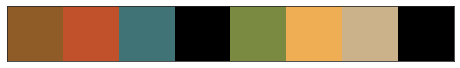

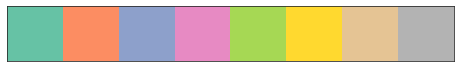

In [27]:
pal_70s = [np.array([143,91,38])/255.0, 
           np.array([193,81,42])/255.0,
           np.array([64,115,117])/255.0,
           np.array([0,0,0])/255.0, 
           np.array([122,138,65])/255.0,
           np.array([239,174,84])/255.0,
           np.array([203,178,139])/255.0,
              np.array([0,0,0])/255.0]
sns.palplot(pal_70s)
pal = sns.color_palette("Set2",n_colors=8)
sns.palplot(pal)
pal = pal_70s

In [28]:
#This is our baseline dictionary which we modify for various conditions. 
#Doing so ensures that we do not inadvertently set a parameter off baseline. 
baseline = dict(name='baseline',
                plot='All',
                num_sims=500,
                data_location = 'data_loc',
                nudge=1, 
                color=np.array([38,38,38])/255.0,
                stop_at=np.inf, 
                decay_value=1,
                vcb_value=1, 
                decay_start=np.inf, 
                p_decay=0,
                p_remove = 0,
                freq=5)
#Add removal at various delays
recs = [baseline]
stops = [15,30,60,120,240]
stop_palette = np.array(sns.dark_palette(pal[0], reverse=True, n_colors=len(stops)+1))[1:]
for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = 1
    add_row['p_remove'] = 1
    add_row['decay_start'] = stops[idx]
    add_row['stop_at'] = stops[idx]
    add_row['color'] = stop_palette[idx]
    add_row['name'] = 'removal_' + str(stops[idx])
    recs.append(add_row)

#Add probababilistic removal 
for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = 1
    add_row['p_remove'] = .2
    add_row['decay_start'] = stops[idx]
    add_row['stop_at'] = stops[idx]
    add_row['color'] = stop_palette[idx]
    add_row['name'] = 'prob_removal_' + str(stops[idx])
    recs.append(add_row)
    
#Add virality circuit breaker applied to all posts
vcb_palette = np.array(sns.dark_palette(pal[-3], reverse=True, n_colors=len(stops)+1))[1:]

for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = 1
    add_row['decay_start'] = stops[idx]
    add_row['vcb_value'] = .9
    add_row['color'] = vcb_palette[idx]
    add_row['name'] = 'vcb_' + str(stops[idx])
    recs.append(add_row)
    
#Add virality circuit breaker applied probabalistically 
vcb_palette = np.array(sns.dark_palette(pal[-3], reverse=True, n_colors=len(stops)+1))[1:]
for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = .2
    add_row['decay_start'] = stops[idx]
    add_row['vcb_value'] = .9
    add_row['color'] = vcb_palette[idx]
    add_row['name'] = 'prob_vcb_' + str(stops[idx])
    recs.append(add_row)
    
#Add nudges
nudges = [.95,.9,.8,.6]
nudge_palette = sns.dark_palette(pal[2], reverse=False, n_colors=len(nudges)+1)[1:]
for idx in range(len(nudges)):
    add_row = baseline.copy()
    add_row['nudge'] = nudges[idx]
    add_row['color'] = np.array(nudge_palette[idx])
    add_row['name'] = 'nudge_' + str(nudges[idx])
    recs.append(add_row)
    


#Add bans
bans=['10K_loc','50K_loc','100K_loc','500K_loc'][::-1]
ban_palette = sns.dark_palette(pal[1], reverse=False, n_colors=len(nudges)+1)[1:]
for idx in range(len(bans)):
    add_row = baseline.copy()
    add_row['data_location'] = bans[idx]
    add_row['color'] = ban_palette[idx]
    add_row['name'] = 'bans_' + str(bans[idx].split('_')[0])
    recs.append(add_row)

bans=['verified_loc','currently_loc']
ban_palette = [np.array([29,161,242])/255.0, pal[6]]
for idx in range(len(bans)):
    add_row = baseline.copy()
    add_row['data_location'] = bans[idx]
    add_row['color'] = ban_palette[idx]
    add_row['name'] = 'bans_' + str(bans[idx].split('_')[0])
    recs.append(add_row)


#Add modest combined simulation
add_row = baseline.copy()
add_row['p_decay'] = .05
add_row['p_remove'] = .2
add_row['decay_start'] = 120
add_row['stop_at'] = 240
add_row['vcb_value'] = .9
add_row['nudge'] = .9
add_row['data_location'] = 'modest_loc'
add_row['color'] = pal[-4]
add_row['name'] = 'modest_0'
recs.append(add_row)

      
    
#Add decay only version of modest policy
add_row = baseline.copy()
add_row['p_decay'] = .05
add_row['p_remove'] = .2
add_row['decay_start'] = 120
add_row['stop_at'] = 240
add_row['vcb_value'] = .9
add_row['color'] = pal[-3]
add_row['name'] = 'modest_decay_only'
recs.append(add_row)


#Add nudge only version of modest policy 
add_row = baseline.copy()
add_row['nudge'] = .9
add_row['color'] = pal[2]
add_row['name'] = 'modest_nudge_only'
recs.append(add_row)

#Add ban only version of modest policy 
add_row = baseline.copy()
add_row['data_location'] = 'modest_loc'
add_row['color'] = pal[1]
add_row['name'] = 'modest_ban_only'
recs.append(add_row)

#Add aggressive combined simulation
add_row = baseline.copy()
add_row['p_decay'] = .10
add_row['p_remove'] = .2
add_row['decay_start'] = 60
add_row['stop_at'] = 120
add_row['vcb_value'] = .8
add_row['nudge'] = .8
add_row['data_location'] = 'aggressive_loc'
add_row['color'] = pal[-4]
add_row['name'] = 'aggressive_0'
recs.append(add_row)


#Add decay only version of aggressive policy
add_row = baseline.copy()
add_row['p_decay'] = .10
add_row['p_remove'] = .2
add_row['decay_start'] = 60
add_row['stop_at'] = 120
add_row['vcb_value'] = .8
add_row['color'] = pal[-3]
add_row['name'] = 'aggressive_decay_only'
recs.append(add_row)

    


#Add nudge only version of aggressive policy 
add_row = baseline.copy()
add_row['nudge'] = .8
add_row['color'] = pal[2]
add_row['name'] = 'aggressive_nudge_only'
recs.append(add_row)



#Add ban only version of aggressive policy 
add_row = baseline.copy()
add_row['data_location'] = 'aggressive_loc'
add_row['color'] = pal[1]
add_row['name'] = 'aggressive_ban_only'
recs.append(add_row)

#Add Combined policy
sim_df = pd.DataFrame.from_records(recs)
sim_df['color'] = [json.dumps(list(item)) for item in sim_df['color']]

#['aggregated_loc','currently_loc','verified_loc']
sim_df.to_csv('./output/simulations/sim_df.csv')


In [29]:
from src.simulation import sim_row

#The keep parameter tells the simulations whether to re-run old simulations (False)
#or keep them. This is very useful if your notebook dies. Just set it to True
#and the simulations will pick up where they left off. 
sim_included = lambda row: sim_row(row, included,verbose=True,keep=False)
_ = sim_df.T.parallel_apply(sim_included)


In [30]:
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [31]:
sim_df = pd.read_csv('./output/simulations/sim_df.csv')


In [32]:
baseline = pickle.load(open('./output/simulations/baseline.p','rb'))

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

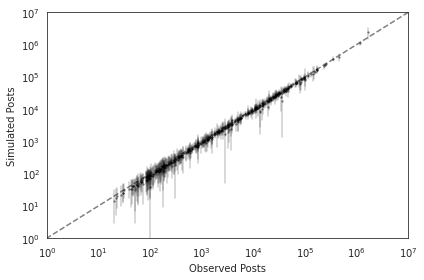

In [34]:
xs = np.zeros(included.shape[0])
ys = np.zeros(included.shape[0])
for idx in range(included.shape[0]):
    x=np.median(np.sum(baseline[included.iloc[idx]['event_name']],axis=1))
    ci=np.percentile(np.sum(baseline[included.iloc[idx]['event_name']],axis=1), 
                     q=[5.5,50, 94.5])
    y= ci[1]
    ci= [ci[0], ci[2]]

    x=included.iloc[idx]['observed_engagement']
    plt.scatter(x,y,color='k',alpha=.5,s=5,linewidth=0)
    plt.plot([x,x], [ci[0], ci[1]],alpha=.2, color='k')
    xs[idx] =x 
    ys[idx] = y
plt.plot([0, 1e7],[0, 1e7],ls='--',color='k',alpha=.5)

plt.xlabel('Observed Posts')
plt.ylabel('Simulated Posts')
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylim(1,1e7)
plt.xlim(1,1e7)

plt.tight_layout()
plt.savefig('./output/figures/SI/SimulationValidation.png',dpi=400,transparent=False)

<h2>Figures and Tables</h2>

<h3>Figure 1</h3>

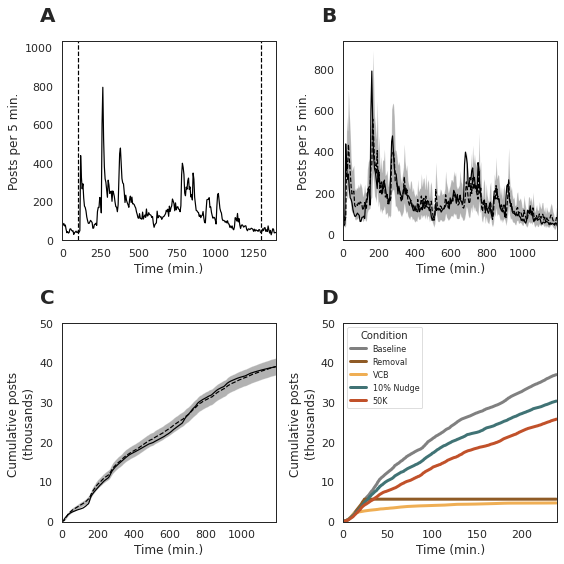

In [128]:
sns.set_context('paper',font_scale=1.25)
sns.set_style('white')

#A not quite random event
#If it breaks when you try a random one it's because
#Figure A adds rows before and after the event
#which isn't possible for all events. 
row_loc = 435
row = included.iloc[row_loc]

from src.figures import plot_figure_1
#The code for figure 1 is a bit messy. 
#The simulations and plotting for individual events
#Is a little duct-tapey. 


    
plot_figure_1(row, included,pal,root='.')


plt.savefig('./output/figures/MS/Fig1.png',dpi=300)

<h3>Figure 2</h3>

In [ ]:
        
def add_sim_line(sim_row,scale=1e6,root='.'):
    vals = pickle.load(open(root + '/output/simulations/' + sim_row['name'] +'.p', 'rb'))
    keys = [key for key in vals.keys()]
    one_output = vals[keys[0]]

    interp_size = 20
    one_output = vals[keys[0]]
    out = np.zeros((one_output.shape[0], interp_size))

    for key in keys:
        one_output = vals[key]
        cumulative_scaled = np.apply_along_axis(interp,arr=np.cumsum(one_output,axis=1),axis=1)
        out+= cumulative_scaled

    mu = np.median(out,axis=0)/scale
    ci = np.percentile(out,axis=0, q=[5.5,94.5])/scale
    xvals = np.linspace(0,1,interp_size)
   
 
    color = json.loads(sim_row['color'])
    plt.plot(xvals, mu,color=color)
    plt.fill_between(xvals, ci[0], ci[1],alpha=.4,facecolor=color, label=sim_row['name'])
    
    return out

def plot_sims(order, sim_df, legend_title, legend_column):
    for idx in order:
        _ = add_sim_line(sim_df.iloc[idx])

    labels = sim_df.iloc[order][legend_column].values.astype('str').tolist()
    labels[0] = 'Base.'
    legend = plt.legend(labels=labels,title=legend_title,loc=2,prop={'size': 8})
    legend.get_title().set_fontsize('10')
    plt.ylim(0,12)
    plt.xlim(0,1)
    plt.xlabel('Time (normalized)')
    plt.ylabel('Cumulative posts')

In [37]:
from src.tables import get_table
order = [0,5,4,3,2,1]
table = get_table(sim_df, order)


In [38]:
from src.tables import get_sim_cumulative


In [ ]:
order = [0,5,4,3,2,1]

def plot_delay(order,sim_df,xtype='stop_at',xmin=0, ymin=0,
               xmax=255, ymax=13,xlabel='Delay (min.)'): 
    baseline = get_sim_cumulative(sim_df.iloc[0])/1000000
    baseline = baseline[:,-1]

    plt.plot([0, xmax], 
             [np.median(baseline),
              np.median(baseline)],
             c='k')
    ax = plt.gca()

    alphas = [.2, .3, .4]
    percentiles = [89, 80, 50]
    for idx in range(1):
        percentile = np.percentile(baseline, 
                                   q=[(100-percentiles[idx])/2,
                                      100-(100-percentiles[idx])/2])
        plt.fill_between([0, 260], 
                 [percentile[0], percentile[0]],
                [percentile[1], percentile[1]],
                color=np.array(json.loads(sim_df.iloc[0]['color'])),
                alpha=alphas[idx])

    medians = []
    for idx in range(1,len(order)):
        temp = get_sim_cumulative(sim_df.iloc[order[idx]])/1000000
        if xtype=='nudge':
            xfunc = lambda x: 100 - (100*x)
        else:
            xfunc = lambda x: x
        medians.append(np.median(temp[:,-1]))
        c=np.array(json.loads(sim_df.iloc[order[idx]]['color']))
        parts = plt.violinplot(temp[:,-1],
                   positions=[xfunc(sim_df.iloc[order[idx]][xtype])],
                   widths=xmax/10,showmedians=False,
                   showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(c)
            pc.set_edgecolor(c)
            pc.set_alpha(.8)

    plt.plot(xfunc(sim_df.iloc[order[1:]][xtype]),medians,color='k',ls='--')


    plt.xlabel(xlabel)
    plt.ylabel('Total posts (millions)')
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
    
from src.figures import plot_sims
from src.tables import get_table
sns.set_context('paper',font_scale=1.25)
sns.set_style('white')

fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.sca(axs[0])
order = [0,5,4,3,2,1]
table = get_table(sim_df, order)
table.to_latex('./output/tables/full_removal.tex',index=False)
plot_delay(order, sim_df)

plt.sca(axs[1])
order = [0,10,9,8,7,6]
table = get_table(sim_df, order)
table.to_latex('./output/tables/partial_removal.tex',index=False)
plot_delay(order, sim_df)

plt.sca(axs[2])
order = [0,15,14,13,12,11]
table = get_table(sim_df, order)
table.to_latex('./output/tables/full_vcb.tex',index=False)
plot_delay(order, sim_df, 'decay_start')


plt.sca(axs[3])
order = [0,20,19,18,17,16]
table = get_table(sim_df, order)
table.to_latex('./output/tables/partial_vcb.tex',index=False)
plot_delay(order, sim_df, 'decay_start')

plt.tight_layout()
plt.savefig('./output/figures/MS/Fig2.png',dpi=400)


In [56]:
def plot_verified_bans(order,sim_df,labels,xmax=30):
    ax = plt.gca()
    baseline = get_sim_cumulative(sim_df.iloc[0])/1000000
    baseline = baseline[:,-1]
    plt.plot([0, 2], 
             [np.median(baseline),
              np.median(baseline)],
             c='k')
    alphas = [.2, .3, .4]
    
    percentiles = [89, 80, 50]
    for idx in range(1):
        percentile = np.percentile(baseline, 
                                   q=[(100-percentiles[idx])/2,
                                      100-(100-percentiles[idx])/2])
        plt.fill_between([0, 260], 
                 [percentile[0], percentile[0]],
                [percentile[1], percentile[1]],
                color=np.array(json.loads(sim_df.iloc[0]['color'])),
                alpha=alphas[idx])

    for idx in range(1,len(order)):
        temp = get_sim_cumulative(sim_df.iloc[order[idx]])/1000000
        c=np.array(json.loads(sim_df.iloc[order[idx]]['color']))
        parts = plt.violinplot(temp[:,-1],
                   positions=[idx-.5],
                   widths=xmax/10,showmedians=False,
                   showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(c)
            pc.set_edgecolor(c)
            pc.set_alpha(.8)
    plt.xticks(np.arange(len(order)-1)+1-.5, 
               labels[1:])
    plt.ylabel('Total posts (millions)')
    plt.xlabel("Policy")
    plt.xlim(0,2)
    plt.ylim(0,13)

    
    
def plot_three_strikes_bans(order,sim_df,labels,xmax=50):
    ax = plt.gca()
    baseline = get_sim_cumulative(sim_df.iloc[0])/1000000
    baseline = baseline[:,-1]
    plt.plot([0, len(order)-1], 
             [np.median(baseline),
              np.median(baseline)],
             c='k')
    alphas = [.2, .3, .4]
    
    percentiles = [89, 80, 50]
    for idx in range(1):
        percentile = np.percentile(baseline, 
                                   q=[(100-percentiles[idx])/2,
                                      100-(100-percentiles[idx])/2])
        plt.fill_between([0, 260], 
                 [percentile[0], percentile[0]],
                [percentile[1], percentile[1]],
                color=np.array(json.loads(sim_df.iloc[0]['color'])),
                alpha=alphas[idx])

    medians = []
    for idx in range(1,len(order)):
        temp = get_sim_cumulative(sim_df.iloc[order[idx]])/1000000
        c=np.array(json.loads(sim_df.iloc[order[idx]]['color']))
        parts = plt.violinplot(temp[:,-1],
                   positions=[idx-.5],
                   widths=xmax/10,showmedians=False,
                   showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(c)
            pc.set_edgecolor(c)
            pc.set_alpha(.8)
        medians.append(np.median(temp[:,-1]))
    plt.plot(np.arange(1,len(order))-.5, medians, ls='--', c='k')
    plt.xticks(np.arange(len(order)-1)+1-.5, 
               labels[1:])
    plt.ylabel('Total posts (millions)')
    plt.xlabel('Follower threshold')
    plt.xlim(0,len(order)-1)
    plt.ylim(0,13)
order = [0,25,26,27,28]

In [131]:
from src.figures import plot_sims
from src.tables import get_table
sns.set_context('paper',font_scale=1.25)
sns.set_style('white')
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.sca(axs[0])
order = [0,21,22,23,24]

table = get_table(sim_df, order)
table.to_latex('./output/tables/nudge.tex',index=False)

plot_delay(order,sim_df, 'nudge', xlabel='Nudge (%)',xmax=50)

plt.sca(axs[1])
ban_df = pd.read_csv(root + '/data/ban_df_counts.csv')
temp_pal = sns.dark_palette(pal[1], reverse=True, n_colors=len(nudges)+1)[1:]
temp_pal.append( np.array([29,161,242])/255.0)
temp_pal.append(np.array(pal[-4]))
temp_pal.append(pal[-4])
temp_pal.append(pal[6])

sns.barplot(ban_df['Total removed'],
            ban_df['Policy'], palette=temp_pal)
plt.ylabel('')

plt.sca(axs[2])
order = [0,29,30]
table = get_table(sim_df, order)
table.to_latex('./output/tables/ban_current_verified.tex',index=False)

labels = ['Baseline', 'Verified', 'Currently']
plot_verified_bans(order,sim_df,labels,xmax=4)


plt.sca(axs[3])
order = [0,28,27,26,25]
table = get_table(sim_df, order)
table.to_latex('./output/tables/ban_threshold.tex',index=False)
plot_three_strikes_bans(order, sim_df, labels = ['Base','10K', '50K', '100K', '500K'],xmax=6)

plt.tight_layout()
plt.savefig('./output/figures/MS/Fig3.png',dpi=400)

/tmp/ipykernel_60756/2745608369.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex('./output/tables/nudge.tex',index=False)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_60756/2745608369.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `Data

Error in callback <function flush_figures at 0x7f4038ecf0d0> (for post_execute):


KeyboardInterrupt: 

<h3>Figure 3</h3>


<h2> Total reduction in engagment </h2>

In [82]:
incidents = pd.read_csv('./data/incidents.csv')
events = pd.read_csv('./data/events_fitted.csv')

In [83]:
import src.adjustment as srcadj
max_events_incidents = srcadj.get_adjusted_df(events,incidents)
srcadj.print_engagment(max_events_incidents)

Total engagement
22924801.0
Before Engagement Total, Percent
7854266.0
34.26
During Engagement Total, Percent
9285231.0
40.50
After Engagement Total, Percent
5785304.0
25.24


In [84]:
neg_binom_glm = pystan.StanModel(file='./src/neg_binom.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bcb3372f83e3dafe0adb2f026e6c7f1d NOW.
In file included from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/pystan_k4twu5a8/stanfit4anon_model_bcb3372f83e3dafe0adb2f026e6c7f1d_8078906075052769134.cpp:777:
/opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /opt/conda/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/prob/poisson_log_glm_log.hpp:5,
                 from /op

In [85]:
neg_binom_samples,x_sim = srcadj.sample_neg_binom(neg_binom_glm, max_events_incidents)
print(pystan.stansummary(neg_binom_samples,pars=['beta','sigma']))



Gradient evaluation took 6.5e-05 seconds
Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 7.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: lognormal_lpdf: Scale parameter is inf, but must be finite!  (in 'neg_binom.stan' at line 22)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: lognormal_lpdf: Scale parameter is 0, but must be > 0!  (in 'neg_binom.stan' at line 22)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of

Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.132054 seconds (Warm-up)
               0.096802 seconds (Sampling)
               0.228856 seconds (Total)

Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.140573 seconds (Warm-up)
               0.129585 seconds (Sampling)
               0.270158 seconds (Total)

Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.139227 seconds (Warm-up)
               0.158632 seconds (Sampling)
               0.297859 seconds (Total)

Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.140521 seconds (Warm-up)
               0.158207 seconds (Sampling)
               0.298728 secon

In [86]:
ci_beta = np.percentile(neg_binom_samples['beta'], q=[5.5,50,94.5])
ci_sigma = np.percentile(neg_binom_samples['beta'], q=[5.5,50,94.5])
outrows = []

for name in ['beta','sigma']:
    ci = np.percentile(neg_binom_samples[name], q=[5.5,50,94.5])
    print(ci)
    outrows.append({'name':name,
     '$\mu (\% change)$':ci[1], 
     '5.5\%':str(np.round(ci[0],2)),
     '94.5\%':str(np.round(ci[2],2))})
pd.DataFrame(outrows).to_latex('./output/tables/LogNormalRegression.tex',index=False)

[0.92022351 0.93543275 0.95030426]
[1.20351421 1.29466952 1.39795551]


/tmp/ipykernel_60756/499217796.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(outrows).to_latex('./output/tables/LogNormalRegression.tex',index=False)


In [87]:
import src.adjustment as srcadj
order = [0,36,37,38,35]

plot_dfs,colors = srcadj.get_plot_df(order,max_events_incidents, sim_df, neg_binom_samples)

ERROR! Session/line number was not unique in database. History logging moved to new session 1082


/tmp/ipykernel_60756/2025207960.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex('./output/tables/modest.tex',index=False)
/tmp/ipykernel_60756/2025207960.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex('./output/tables/aggressive.tex',index=False)


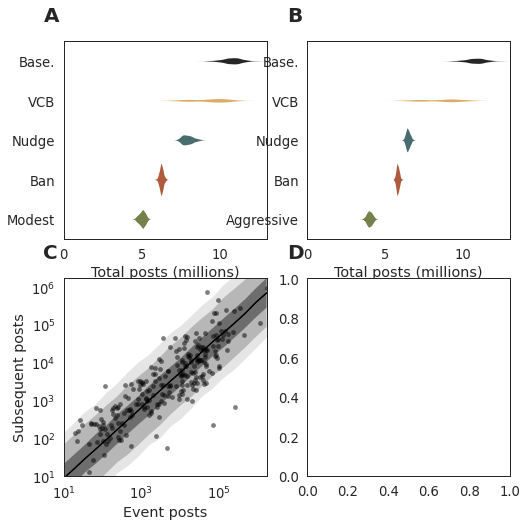

In [ ]:

import seaborn as sns
from src.figures import plot4c

fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.sca(axs[0])   
order = [0,32,33,34,31]
table = get_table(sim_df, order)
table.to_latex('./output/tables/modest.tex',index=False)

dfs = []
labels = ['Base.','VCB', 'Nudge', 'Ban', 'Modest' ] #Double check label ordering
for idx in range(len(order)):
    temp = get_sim_cumulative(sim_df.iloc[order[idx]])[:,-1]/1000000
    dfs.append(pd.DataFrame({'condition': np.repeat(labels[idx], temp.shape), 
                   'posts':temp}))
sns.violinplot(x='posts', y='condition', alpha=.8,linewidth=0, data=pd.concat(dfs), palette=[json.loads(color) for color in colors])
plt.xlabel('Total posts (millions)')
plt.xlim(0,13)

plt.ylabel('')



plt.sca(axs[1])   
order = [0,36,37,38,35]
table = get_table(sim_df, order)
table.to_latex('./output/tables/aggressive.tex',index=False)

dfs = []    
labels = ['Base.','VCB', 'Nudge', 'Ban', 'Aggressive' ] #Double check label ordering
for idx in range(len(order)):
    temp = get_sim_cumulative(sim_df.iloc[order[idx]])[:,-1]/1000000
    dfs.append(pd.DataFrame({'condition': np.repeat(labels[idx], temp.shape), 
                   'posts':temp}))
sns.violinplot(x='posts', y='condition',linewidth=0,alpha=.8, data=pd.concat(dfs), 
               palette=[json.loads(color) for color in colors])
plt.xlim(0,13)

plt.xlabel('Total posts (millions)')
plt.ylabel('')


#Define some values to simulate in generated quantities block
x_sim = np.logspace(np.log(np.min(max_events_incidents['observed_engagement'])-10),
                np.log(np.max(max_events_incidents['observed_engagement'])+20),20,base=np.e)
plt.sca(axs[2])
plot4c(neg_binom_samples, max_events_incidents,x_sim)

plt.sca(axs[3])
sns.violinplot(y='name', x='total_adjusted',linewidth=0, alpha=.8, data=plot_dfs,palette=[json.loads(color) for color in colors])
plt.xlim(0,13)
plt.xlabel('Post-event engagement\n(millions of posts)')
plt.ylabel(None)
plt.xlim(0,)
plt.tight_layout()
plt.savefig('./output/figures/MS/Fig4.png',dpi=300)

In [93]:
order = [0,32,33,34,31]
table = get_table(sim_df, order)
plot_dfs_modest,colors_modest = srcadj.get_plot_df(order,max_events_incidents, sim_df, neg_binom_samples)

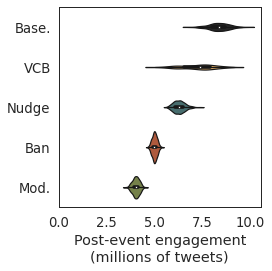

In [145]:
sns.set_style('white')
sns.set_context('paper',font_scale=1.5)
plt.figure(figsize=(4,4))
sns.violinplot(y='name', x='total_adjusted',data=plot_dfs_modest,palette=[json.loads(color) for color in colors])
plt.xlabel('Post-event engagement\n(millions of tweets)')
plt.ylabel(None)
plt.xlim(0,)
plt.tight_layout()
plt.savefig('./output/figures/SI/SIModest.png',dpi=300)

<h3>Revision analysis</h3>

In [94]:
from ast import literal_eval
import arviz as az
def get_params(sim_row,included,keep=False, verbose=False):
    param_list = ['beta','decay','alpha','inv_phi', 'lambda','phi']
    save_loc = './output/simulations/' + sim_row['name'] + '.p'
    if keep and os.path.isfile(save_loc):
        pass 
    else:       
        out_dicts = []
        
        if verbose:  
            iterator = tqdm(included.shape[0])
        else:
            iterator = range(included.shape[0])
            
        for ridx in iterator:
            row = included.iloc[ridx]
            model = pickle.load(open('./output/posteriors/model.p','rb'))
            samples = pickle.load(open(row['sample_loc'],'rb'))
            samps = az.summary(samples,var_names=param_list)
            to_gather = ['mean','hdi_3%','hdi_97%']
            row_items = {}
            for item in to_gather: 
                row_items.update(dict(zip(samps[item].keys()+'_' + item,samps[item].values)))
            row_items.update(row)
            out_dicts.append(row_items)
        
    return pd.DataFrame(out_dicts)  



In [95]:
samples = get_params(sim_df.iloc[0],included)

In [96]:
samples['log10(posts)'] = np.floor(np.log(samples['observed_engagement']))


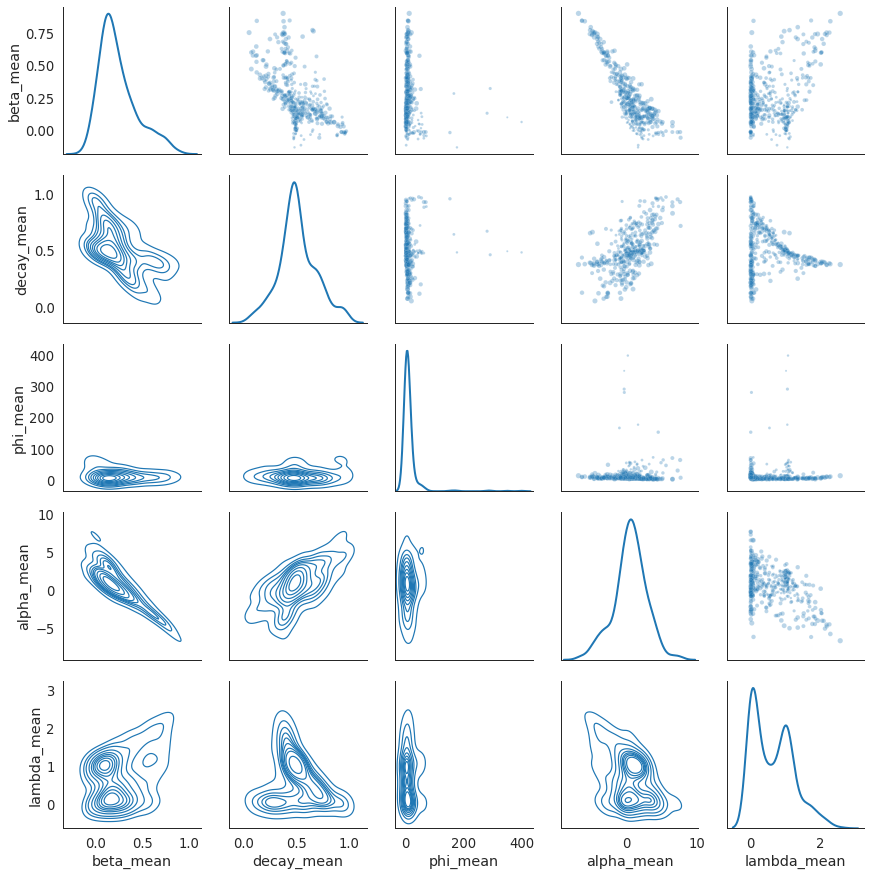

In [146]:
g=sns.PairGrid(samples,x_vars=['beta_mean','decay_mean','phi_mean','alpha_mean','lambda_mean'],
            y_vars=['beta_mean','decay_mean','phi_mean','alpha_mean','lambda_mean'],
               diag_sharey=False,)
# hue='log10(posts)',palette=sns.dark_palette("#69d", reverse=True, as_cmap=False)
g.map_upper(sns.scatterplot, s=2*samples['log10(posts)'],alpha=.3)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
plt.savefig('./output/figures/SI/parameter_pair_plot.png',dpi=400)

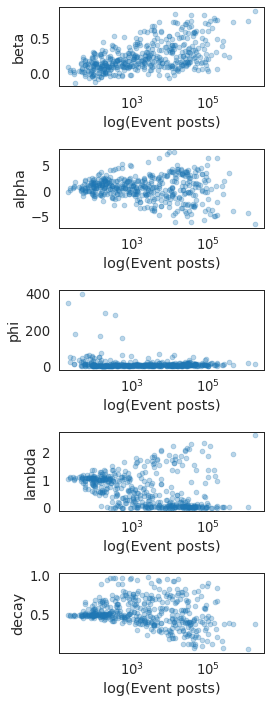

In [98]:
plt.figure(figsize=(4,10))
plt.subplot(511)
plt.scatter(samples['observed_engagement'],samples['beta_mean'],alpha=.3)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel("log(Event posts)")
plt.ylabel('beta')

plt.subplot(512)
plt.scatter(samples['observed_engagement'],samples['alpha_mean'],alpha=.3)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel("log(Event posts)")
plt.ylabel('alpha')

plt.subplot(513)
plt.scatter(samples['observed_engagement'],samples['phi_mean'],alpha=.3)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel("log(Event posts)")
plt.ylabel('phi')

plt.subplot(514)
plt.scatter(samples['observed_engagement'],samples['lambda_mean'],alpha=.3)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel("log(Event posts)")
plt.ylabel('lambda')


plt.subplot(515)
plt.scatter(samples['observed_engagement'],samples['decay_mean'],alpha=.3)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel("log(Event posts)")
plt.ylabel('decay')

plt.tight_layout()
plt.savefig('./output/figures/SI/params_v_posts.png',dpi=400)

<h3>Misc Calculations</h3>

In [99]:
samples['observed_engagement']

0           88.0
1           20.0
2           55.0
3           70.0
4          262.0
         ...    
449     149838.0
450    1136546.0
451     243082.0
452    1686989.0
453      97690.0
Name: observed_engagement, Length: 454, dtype: float64

In [100]:
events.shape

(544, 23)

In [101]:
(544-457)/544

0.15992647058823528

In [102]:
events['incident'].unique().size

269

In [103]:
events.shape

(544, 23)

In [104]:
np.sum(events['included'])

454

In [105]:
events[events['included']==True]['observed_engagement'].sum()/events['observed_engagement'].sum()

0.7164025905754136

In [106]:
np.min(samples['observed_engagement'])

20.0

In [107]:
events[events['included']==True]['observed_engagement'].min()

20.0

In [108]:
events[events['included']==True]['observed_engagement'].max()

1686989.0

In [118]:
events[events['included']==True]['duration'].max()*5/60

83.16666666666667

In [109]:
events[events['included']==True]['observed_engagement'].sum()

10478393.0

In [110]:
events['observed_engagement'].sum()

14626403.0

In [111]:
events[events['included']==True].shape

(454, 23)

In [112]:
events.shape

(544, 23)

In [113]:
events['incident'].unique().shape

(269,)